# Workflow

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import sys

sys.path.append('../hydra_TOD/')

from astropy.coordinates import EarthLocation, AltAz, SkyCoord
from astropy.time import Time, TimeDelta
import astropy.units as u
from utils import Leg_poly_proj, view_samples
from flicker_model import sim_noise, flicker_cov
from simulation import * 

## A. Simulation

In [2]:
nside = 64

### 1. Define the two scans (rising and setting)
Tsky parameters and operators

In [3]:
# Get the timestream of beam centers (theta_c, phi_c) for each scan
t_list, theta_c_setting, phi_c_setting = sim_MeerKAT_scan(elevation=41.5, az_s=-60.3, az_e=-42.3, start_time_utc="2019-04-23 20:41:56.397")
bool_map_setting, integrated_beam_setting = stacked_beam_map(theta_c_setting, 
                                       phi_c_setting, 
                                       FWHM=1.1, 
                                       NSIDE=nside, 
                                       threshold = 0.0111) # This threshold cut off the beam directions outside the 3sigma region.

In [4]:
full_bool_map = bool_map_setting
pixel_indices = np.where(full_bool_map)[0]
integrated_beam = integrated_beam_setting 

Tsky_operator_setting = generate_Tsky_proj(full_bool_map, theta_c_setting, phi_c_setting, FWHM=1.1)

In [5]:
def sky_vector(pixel_indices, freq, Nside=64, sky_model=None):
    if sky_model is None:
        from pygdsm import GlobalSkyModel
        gsm = GlobalSkyModel()
        skymap = gsm.generate(freq)
    else:
        skymap = sky_model(freq)
    skymap = hp.ud_grade(skymap, nside_out=Nside)
    ptsrc = np.load("gleam_nside512_K_allsky_408MHz.npy")
    ptsrc_map = hp.ud_grade(ptsrc, nside_out=Nside)
    skymap = skymap + ptsrc_map
    return skymap[pixel_indices]

sky_params = sky_vector(pixel_indices, 408, Nside=nside, sky_model=None)
print("Number of pixels: ", len(pixel_indices))

Number of pixels:  375


### 2. Define Tdiode and Trec

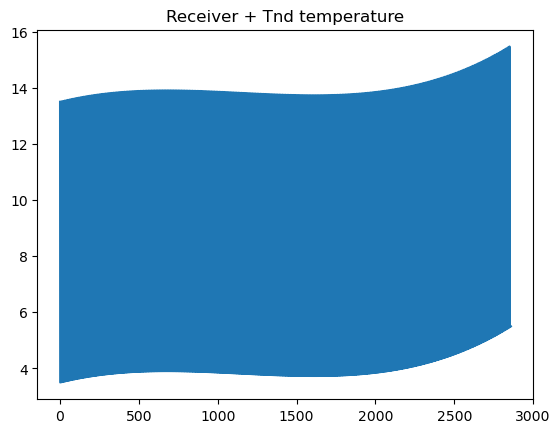

In [6]:
# generate a vector of length ntime, every 10 elements there is a 1, the rest is 0
def generate_vector(ntime):
    vector = np.zeros(ntime)
    for i in range(0, ntime, 10):
        vector[i] = 1
    return vector

ntime = len(t_list)
ndiode_proj = generate_vector(ntime)

nd_rec_operator = np.zeros((ntime, 5))
nd_rec_operator[:, 0] = ndiode_proj    # The noise diode part
nd_rec_operator[:, 1:] = Leg_poly_proj(4, t_list) # The Legendre polynomial (receiver temperature and all) part

T_ndiode = 10.0
rec_params=np.array([4, 0.5, 0.5, 0.5]) # The receiver temperature and all
nd_rec_params = np.zeros(5)
nd_rec_params[0] = T_ndiode
nd_rec_params[1:] = rec_params

plt.title("Receiver + Tnd temperature")
plt.plot(nd_rec_operator @ nd_rec_params)

### 3. Define Gain and Noise

In [7]:
gain_proj = Leg_poly_proj(4, t_list)

#gain_params_setting = np.random.uniform(low=0.0, high=1.0, size=4) + np.array([6., 0., 0., 0.])

gain_params_setting = np.array([6.31194264, 0.42038942, 0.264222, 0.05578821])

gains_setting = gain_proj @ gain_params_setting
print(gain_params_setting)
# save the gain parameters
# np.savez('outputs/sim0_log_gain/gain_params.npy', gain_params_setting)

[6.31194264 0.42038942 0.264222   0.05578821]


In [8]:
dtime = 2
fc = (1/ntime/dtime)*2*np.pi
logfc = np.log10(fc)
alpha = 2.0
logf0_list=[-4.874571109426952, -3.874259892646189, -2.901434432609383] 
# Corresponding to knee frequencies: 0.001. 0.01, 0.1
sigma_2 = 1/(4e5)

f0 = 10**logf0_list[0]

noise_setting = sim_noise(f0, fc, alpha, t_list, white_n_variance=sigma_2)

In [9]:
Tsys_setting = Tsky_operator_setting @ sky_params + nd_rec_operator @ nd_rec_params 
TOD_setting = Tsys_setting * (1+noise_setting) * gains_setting

## B. Sampling

In [10]:
# Convert theta/phi coordinates to HEALPix pixels
pixels_c_setting = [hp.ang2pix(nside=nside, theta=theta, phi=phi)
          for theta, phi in zip(theta_c_setting, phi_c_setting)]
bool_map_c_setting = np.zeros(hp.nside2npix(nside))
bool_map_c_setting[pixels_c_setting] = 1

In [11]:
# For a 1D array 'integrated_beam_setting'
n_cal_pixs=1
top_20_beam_indices = np.argpartition(integrated_beam_setting[pixel_indices], -20)[-20:]
top_n_sky_indices = np.argpartition(sky_params[top_20_beam_indices], -n_cal_pixs)[-n_cal_pixs:]
calibration_indices = top_20_beam_indices[top_n_sky_indices]

In [12]:
init_Tsys_params = np.hstack([sky_params, nd_rec_params])
init_noise_params = [-4.8, 2.2]

gain_prior_cov_inv = np.ones(4)*0.
#gain_prior_cov_inv[0, 0] = 1.
gain_prior_mean = np.array([np.log10(6), 0., 0., 0.])

Tsky_prior_cov_inv = np.ones_like(sky_params) * 0.
Tsky_prior_cov_inv[calibration_indices] = 1e20

Trec_prior_cov_inv = [np.zeros_like(nd_rec_params)] # Effectlively no prior

# logfc_c= np.log10(fc)
# def log_prior_noise(params):
#     _, logfc, _ = params
#     return -1e10 * (logfc_c - logfc)**4 # Effectively constrain f_c


In [13]:
# class TOD_sim:
#     def __init__(self, t_list, theta_c, phi_c, 
#                  TOD, gain_proj, Tsky_proj, nd_rec_proj,
#                  ):
#         self.t_list = None
#         self.theta_c = None
#         self.phi_c = None

In [14]:
from full_Gibbs_sampler import full_Gibbs_sampler_multi_TODS_v2

Tsys_samples, all_gain_samples, all_noise_samples = \
    full_Gibbs_sampler_multi_TODS_v2([TOD_setting],
                                    [t_list],
                                    [gain_proj],
                                    [Tsky_operator_setting],
                                    [nd_rec_operator],
                                    init_Tsys_params,
                                    init_noise_params, 
                                    [logfc],
                                    num_Jeffrey=False,
                                    wnoise_var=2.5e-6,
                                    Tsky_prior_cov_inv=Tsky_prior_cov_inv,
                                    Tsky_prior_mean=sky_params,
                                    local_Trec_prior_cov_inv_list=Trec_prior_cov_inv,
                                    local_Trec_prior_mean_list=[nd_rec_params],
                                    local_gain_prior_cov_inv_list=[gain_prior_cov_inv],
                                    local_gain_prior_mean_list=[gain_prior_mean],
                                    #local_noise_prior_func_list=[log_prior_noise, log_prior_noise],
                                    log_linear_gain=True,
                                    n_samples=300,
                                    tol=1e-12)

Rank: 0, local id: 0, gain_sample 0: [0.79976752 0.02844034 0.01711355 0.00362263]
Rank: 0, local id: 0, noise_sample 0: [-4.47096247  2.28849793]
Reached max iterations with fractional norm error 0.0015805047095931587.
Rank: 0, local id: 0, gain_sample 1: [0.79973084 0.02852271 0.0173819  0.0033826 ]
Rank: 0, local id: 0, noise_sample 1: [-5.24748518  1.62377763]
Reached max iterations with fractional norm error 0.0005844771478775745.
Rank: 0, local id: 0, gain_sample 2: [0.79982718 0.0287575  0.01742341 0.00299034]
Rank: 0, local id: 0, noise_sample 2: [-4.72553672  1.66214178]
Reached max iterations with fractional norm error 0.0002187866320264925.
Rank: 0, local id: 0, gain_sample 3: [0.79995187 0.02853576 0.01793314 0.00337789]
Rank: 0, local id: 0, noise_sample 3: [-4.05344147  2.04116006]
Reached max iterations with fractional norm error 0.00047949720720305035.
Rank: 0, local id: 0, gain_sample 4: [0.79997684 0.02855938 0.01860371 0.00220141]
Rank: 0, local id: 0, noise_sample 4

/Users/zzhang/Workspace/flicker/notebooks/../hydra_TOD/gain_sampler.py:42: RuntimeWarning: invalid value encountered in log10
  d_vec = np.log10(data/Tsys)


Rank: 0, local id: 0, gain_sample 43: [nan nan nan nan]


/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f +

Rank: 0, local id: 0, noise_sample 43: [-4.87754758  2.4644519 ]
Reached max iterations with fractional norm error nan.
Rank: 0, local id: 0, gain_sample 44: [nan nan nan nan]


/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f +

emcee: Exception while calling your likelihood function:
  params: [-5.31371255  2.28790974]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

#### Visualize the Tsky samples

In [ ]:
# First, save the samples as npy files..

np.save("outputs/sim0_log_gain/Tsys_samples.npy", Tsys_samples)
np.save("outputs/sim0_log_gain/gain_samples.npy", np.concatenate(all_gain_samples, axis=0))
np.save("outputs/sim0_log_gain/noise_samples.npy", np.concatenate(all_noise_samples, axis=0))

In [ ]:
# Read the saved samples

# Tsys_samples = np.load('outputs/sim0_log_gain/Tsys_samples.npy')


In [ ]:
num_pixels = len(pixel_indices)
Tsky_samples = Tsys_samples[:, :num_pixels]
Tmean = np.mean(Tsky_samples, axis=0)
Tstd = np.std(Tsky_samples, axis=0)

NPIX = hp.nside2npix(nside)

true_map = np.zeros(NPIX, dtype=float)
sample_mean_map = np.zeros(NPIX, dtype=float)
sample_std_map = np.zeros(NPIX, dtype=float)

true_map[pixel_indices] = sky_params
sample_mean_map[pixel_indices] = Tmean
sample_std_map[pixel_indices] = Tstd

In [ ]:
def view_patch_map(map, pixel_indices):
    # Create a new map with just the patch (other pixels set to UNSEEN)
    patch_only_map = np.full(len(map), hp.UNSEEN)
    patch_only_map[pixel_indices] = map[pixel_indices]
    return patch_only_map


In [ ]:
# Get pixel coordinates
theta, phi = hp.pix2ang(nside, pixel_indices)
lon, lat = np.degrees(phi), 90 - np.degrees(theta)
lon_center, lat_center = np.median(lon), np.median(lat)

# Calculate appropriate zoom/resolution
patch_size = 100  # Add 20% margin
res = patch_size / 20  # Adjust resolution based on patch size

In [ ]:
sky_min = np.min(sky_params)
sky_max = np.max(sky_params)

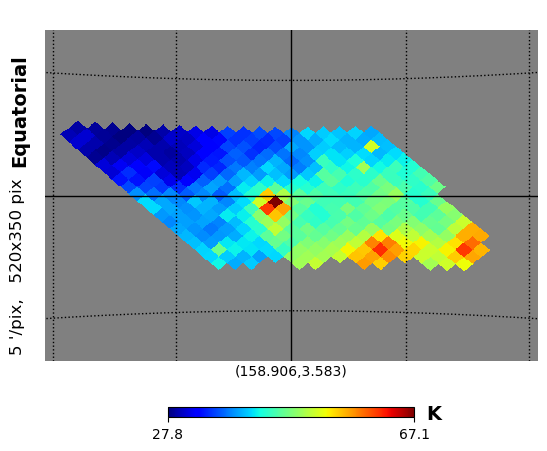

In [ ]:
patch_true_map = view_patch_map(true_map, pixel_indices)

hp.gnomview(patch_true_map, rot=(lon_center, lat_center), 
           xsize=520, ysize=350, reso=res, 
           title=" ", 
           unit="K", cmap='jet', min=sky_min, max=sky_max,
           #notext=True,
           coord=['C'], 
           cbar=True, notext=False, badcolor='gray')
#plt.grid(True)
hp.graticule(dpar=10, dmer=10, coord=['C'], local=True)  
#plt.grid(color='gray', linestyle=':', alpha=0.5)  # Custom grid style
plt.gca().set_facecolor('gray')  # Set background to white
plt.savefig('outputs/sim0_log_gain/true_map.pdf', bbox_inches='tight', 
            pad_inches=0.1)

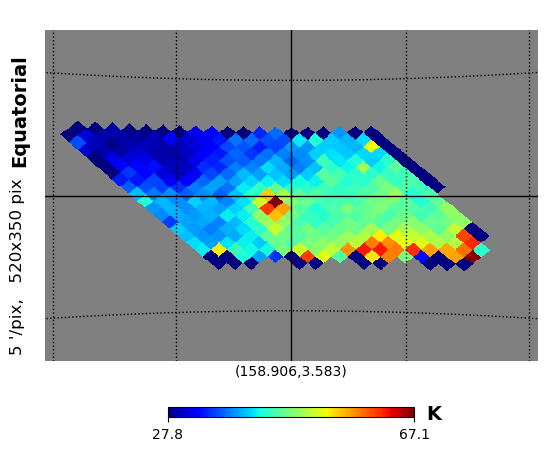

In [ ]:
patch_mean_map = view_patch_map(sample_mean_map, pixel_indices)

hp.gnomview(patch_mean_map, rot=(lon_center, lat_center), 
           xsize=520, ysize=350, reso=res, title=" ", 
           unit="K", cmap='jet', min=sky_min, max=sky_max,
           #notext=True,
           coord=['C'], 
           cbar=True, notext=False, badcolor='gray')
#plt.grid(True)
hp.graticule(dpar=10, dmer=10, coord=['C'], local=True)  
#plt.grid(color='gray', linestyle=':', alpha=0.5)  # Custom grid style
plt.gca().set_facecolor('gray')  # Set background to white
plt.savefig("outputs/sim0_log_gain/mean_map.pdf", bbox_inches='tight', 
            pad_inches=0.1)

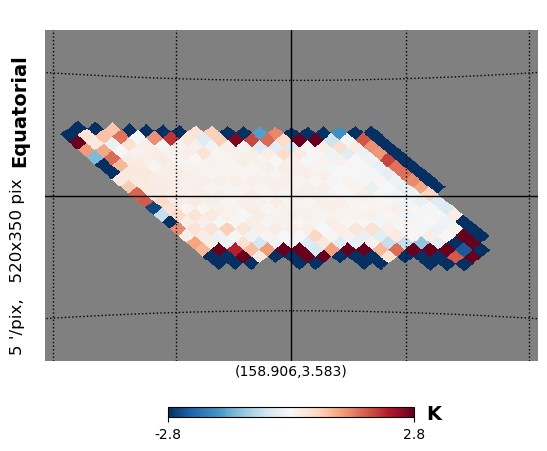

In [ ]:
patch_error_map = view_patch_map(sample_mean_map-true_map, pixel_indices)
# plt.figure(figsize=(10, 6))
hp.gnomview(patch_error_map, rot=(lon_center, lat_center), 
           xsize=520, ysize=350, reso=res, title=" ", 
           unit="K", cmap='RdBu_r', min=-2.8, max=2.8,
           #notext=True,
           coord=['C'], 
           cbar=True, notext=False,
           badcolor='gray')
#plt.grid(True)
hp.graticule(dpar=10, dmer=10, coord=['C'], local=True)  
#plt.grid(color='gray', linestyle=':', alpha=0.5)  # Custom grid style
plt.gca().set_facecolor('gray')  # Set background to white
plt.savefig("outputs/sim0_log_gain/error_map_multi_TOD.pdf", bbox_inches='tight', 
            pad_inches=0.1)

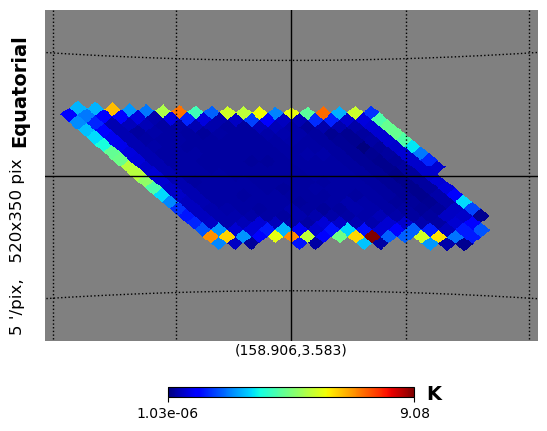

In [ ]:
patch_std_map = view_patch_map(sample_std_map, pixel_indices)

hp.gnomview(patch_std_map, rot=(lon_center, lat_center), 
           xsize=520, ysize=350, reso=res, title=None, 
           unit="K", cmap='jet', 
           notext=False,
           coord=['C'], 
           cbar=True, 
           badcolor='gray',
           #sub=(2, 1, 1),  # Proper subplot specification
           #margins=(0.05, 0.15, 0.05, 0.15)
           )
#plt.grid(True)
hp.graticule(dpar=10, dmer=10, coord=['C'], local=True)  
#plt.grid(color='gray', linestyle=':', alpha=0.5)  # Custom grid style
plt.gca().set_facecolor('gray')  # Set background to white
plt.savefig("outputs/sim0_log_gain/std_map_multi_TOD.pdf", bbox_inches='tight', 
            pad_inches=0.1)

In [ ]:

# # ---- Plot results ----
# # Generate a 2D plot of (RA, Dec) coordinates
# plt.figure(figsize=(12, 6))
# plt.scatter(equatorial_coords_setting.ra, equatorial_coords_setting.dec)
# plt.scatter(equatorial_coords_rising.ra, equatorial_coords_rising.dec)
# plt.xlabel("Right Ascension (degrees)")
# plt.ylabel("Declination (degrees)")
# plt.title("Sky Coordinates at Different Times")
# plt.show()


### Other components

In [ ]:
#gain_samples = np.load("outputs/sim0_log_gain/gain_samples.npy")

In [ ]:
all_noise_samples[0].shape

(1, 80, 2)


 Parameter 1:
True value: -4.874571
Mean sampled: -4.584557
Standard deviation: 0.550058
Relative error: -5.95%

 Parameter 2:
True value: 2.000000
Mean sampled: 1.966844
Standard deviation: 0.483800
Relative error: 1.66%


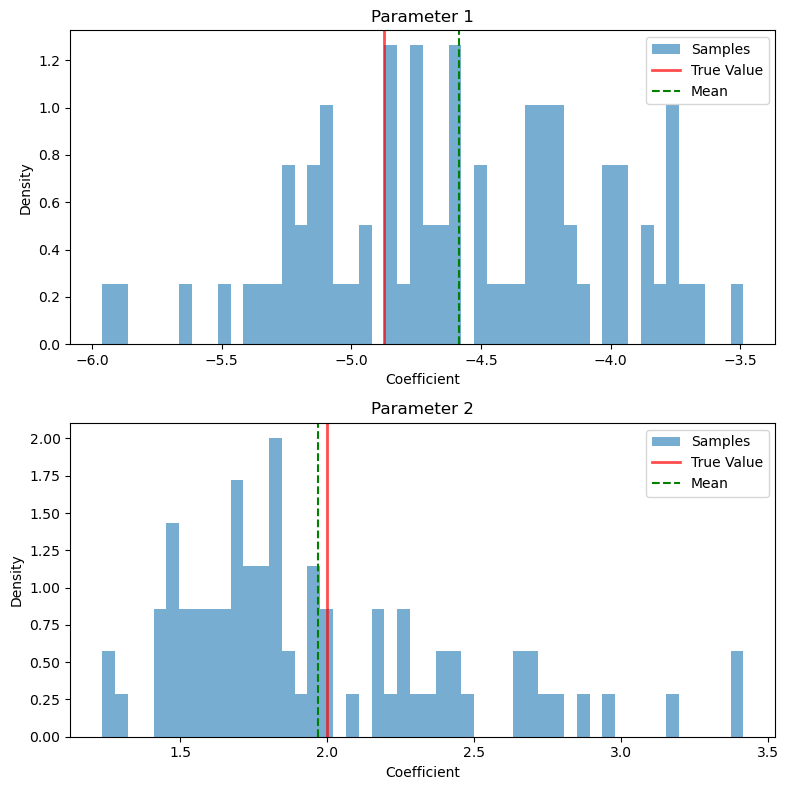

In [ ]:
view_samples(all_noise_samples[0][0], [np.log10(f0), alpha])


 Parameter 1:
True value: 6.046400
Mean sampled: 6.045394
Standard deviation: 0.001533
Relative error: 0.02%

 Parameter 2:
True value: 0.192104
Mean sampled: 0.184567
Standard deviation: 0.005635
Relative error: 3.92%

 Parameter 3:
True value: 0.603280
Mean sampled: 0.592007
Standard deviation: 0.008657
Relative error: 1.87%

 Parameter 4:
True value: 0.245258
Mean sampled: 0.254541
Standard deviation: 0.011151
Relative error: 3.79%


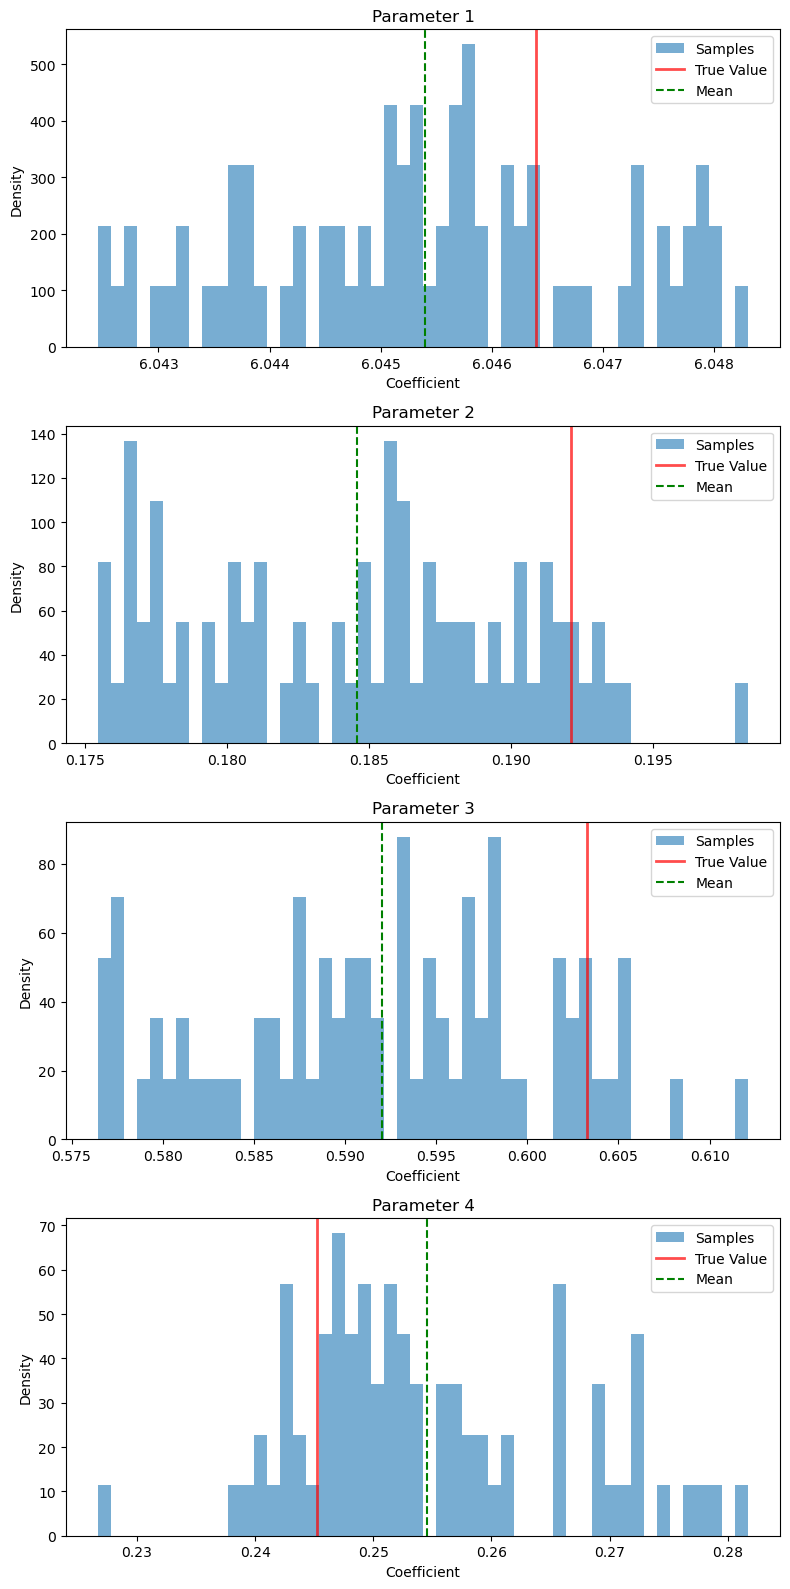

In [ ]:
view_samples(all_gain_samples[0][0], gain_params_setting)

In [ ]:
view_samples(Tsys_samples[:,-5:], nd_rec_params)